In [18]:
import os
import glob
import time

import pandas as pd
import numpy as np
import xarray as xr
import datetime


import matplotlib
from matplotlib import pyplot as plt
from matplotlib.ticker import NullFormatter
matplotlib.rcParams.update({'font.size': 16})
%matplotlib inline
import cartopy.crs as ccrs
import cartopy

from wrfProcessing import *

import sys
p = os.path.abspath('../..')
if p not in sys.path:
    sys.path.append(p)

from orographicPrecipitation.precip_model_functions import qsat
SCRATCH='/global/cscratch1/sd/qnicolas/'

# Functions, data

In [2]:
def extract_wrfout(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='Time',parallel=True)
def extract_wrfpro(simulation_path,nfiles=30): #default extracts 300 days
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    files = files[:min(len(files),nfiles)]
    return xr.open_mfdataset(files,combine='nested',concat_dim='time',parallel=True)

In [3]:
def pressure_delta(column,pressure) :
    """given two arrays of the same length, return the pressure range corresponding to the non-nan values of column.
    e.g. if column = [nan,a,b,c,nan,nan] and pressure=[p1,p2,p3,p4,p5,p6], return p4-p2.
    Doesn't work if there are nans in the middle, eg. column = [nan,a,nan,c,nan,nan] (would still return p4-p2)"""
    
    idxs = np.where(~np.isnan(column))[0]
    try :
        return np.abs(pressure[idxs[-1]]-pressure[idxs[0]])
    except IndexError :
        print("Column only contains nans")
        return np.nan


In [4]:
def pressure_mean(da,vdim='pressure'):
    da_integ = da.fillna(0.).integrate(vdim)
    weights = xr.apply_ufunc(pressure_delta,da,da.pressure,input_core_dims=[['pressure'],['pressure']],vectorize=True)#,dask="parallelized",output_dtypes=float)
    return da_integ/weights



In [5]:
from scipy.integrate import cumtrapz
def A_npy(T,p):
    """T temperature in Kelvin, p in pascal. p must be increasing"""
    assert p[0]<p[1]
    L = 2.26e6
    Cp=1004.
    Rv = 461.
    gamma = L*qsat(T,p/100.)/Rv/T**2 * L/Cp
    kappa=2/7
    bl = np.where(p>95000.)[0]
    freetrop = np.where(p<=95000.)[0]
    integ = 1/(1+gamma[freetrop])*np.exp(kappa*cumtrapz(1/(1+gamma[freetrop][::-1]),np.log(p[freetrop][::-1]),initial=0))[::-1]
    a = np.concatenate([integ,integ[-1]*(p[bl]/p[freetrop][-1])**kappa])
    return  a

def A_npy2(T,p):
    idxs = np.where(~np.isnan(T))[0]
    n=len(p)
    T=T[idxs]
    p=p[idxs]
    a = A_npy(T,p)
    return np.concatenate([[np.nan]*idxs[0] ,a,[np.nan]*(n-1-idxs[-1])])
def A(T,p):
    return xr.apply_ufunc(A_npy2,T,p,input_core_dims=[['pressure'],['pressure']],output_core_dims=[['pressure']],vectorize=True)
    

def Aplus_npy(T,p):
    idxs = np.where(~np.isnan(T))[0]
    n=len(p)
    T=T[idxs]
    p=p[idxs]
    a = A_npy(T,p)
    return np.concatenate([[np.nan]*idxs[0] ,-cumtrapz(a[::-1],np.log(p[::-1]),initial=0)[::-1],[np.nan]*(n-1-idxs[-1])])

def Omega_npy(T,p):
    aplus=Aplus_npy(T,p)
    aplushat = np.trapz(aplus,p)/(p[-1]-p[0])
    return cumtrapz(aplus[::-1]-aplushat,p[::-1],initial=0)[::-1]

def Aplus(T,p):
    return xr.apply_ufunc(Aplus_npy,T,p,input_core_dims=[['pressure'],['pressure']],output_core_dims=[['pressure']],vectorize=True)
    

def pressure_mean(da,vdim='pressure'):
    da_integ = da.fillna(0.).integrate(vdim)
    weights = xr.apply_ufunc(pressure_delta,da,da.pressure,input_core_dims=[['pressure'],['pressure']],vectorize=True)#,dask="parallelized",output_dtypes=float)
    return da_integ/weights

def Omega(T,p):
    aplus=Aplus(T,p)
    aplushat = pressure_mean(aplus)
    return xr.apply_ufunc(lambda ap,aph,pp : cumtrapz(ap[::-1]-aph,pp[::-1],initial=0)[::-1],
                          aplus,aplushat,p,input_core_dims=[['pressure'],[],['pressure']],output_core_dims=[['pressure']],vectorize=True)

def M(Z,q,T,p):
    Lv = 2.26e6
    Cp = 1004.
    g=9.81
    aplus = Aplus(T,p)
    Mq = - pressure_mean(aplus*Lv*q)       + pressure_mean(aplus)*pressure_mean(Lv*q)
    Ms =   pressure_mean(aplus*(Cp*T+g*Z)) - pressure_mean(aplus)*pressure_mean(Cp*T+g*Z)
    return Ms-Mq,Ms,Mq

def Mss(Z,T,p):
    Cp = 1004.
    g=9.81
    aplus = Aplus(T,p)
    return pressure_mean(aplus*(Cp*T+g*Z)) - pressure_mean(aplus)*pressure_mean(Cp*T+g*Z)


In [6]:
def add_text(ax):
    ax.text(0.1, 0.1,'EAST (upstream)', ha='center', va='center', transform=ax.transAxes, fontsize=12,fontweight="heavy")
    ax.text(0.9, 0.1,'WEST (downstream)', ha='center', va='center', transform=ax.transAxes, fontsize=12,fontweight="heavy")

In [7]:
def rad_cooling(sim):
    mSWUPT = (sim.ACSWUPT.isel(Time = -1)-sim.ACSWUPT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWDNT = (sim.ACSWDNT.isel(Time = -1)-sim.ACSWDNT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWUPB = (sim.ACSWUPB.isel(Time = -1)-sim.ACSWUPB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mSWDNB = (sim.ACSWDNB.isel(Time = -1)-sim.ACSWDNB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWUPT = (sim.ACLWUPT.isel(Time = -1)-sim.ACLWUPT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWDNT = (sim.ACLWDNT.isel(Time = -1)-sim.ACLWDNT.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWUPB = (sim.ACLWUPB.isel(Time = -1)-sim.ACLWUPB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    mLWDNB = (sim.ACLWDNB.isel(Time = -1)-sim.ACLWDNB.isel(Time = 0))/(len(sim.Time)-1)/6/3600
    return mSWUPT-mSWDNT-mSWUPB+mSWDNB+mLWUPT-mLWDNT-mLWUPB+mLWDNB

In [8]:
%%time
channelwrf = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x10.mountain.100km.300d/",nfiles=60)
channelwrf_p = extract_wrfpro("/global/cscratch1/sd/qnicolas/wrfdata/processed/channel.wrf.100x10.mountain.100km.300d/",nfiles=30)


CPU times: user 21.7 s, sys: 10.5 s, total: 32.1 s
Wall time: 28.6 s


In [22]:
hgt = channelwrf.HGT.mean(['south_north','Time'])[::-1]
def plotsection(hgt):
    fig, ax = plt.subplots(1,1,figsize=(15,4))
    ax.set_xlabel("distance (°)")
    ax.set_ylabel("height(m)")
    ax.plot(hgt.west_east,hgt,color='k')
    return ax,ax.twinx()

In [9]:
from wrf import cape_2d
import wrf
from netCDF4 import Dataset
from joblib import Parallel, delayed

def compute_individual_cape(file):
    return wrf.getvar(Dataset(file), "cape_2d", timeidx=wrf.ALL_TIMES)

num_cores = 16
wrf.omp_set_num_threads(32)
def compute_cape(simulation_path):
    files=sorted(glob.glob(simulation_path+'wrfout_d01_197*'))
    capecin_list = Parallel(n_jobs=num_cores)(delayed(compute_individual_cape)(file) for file in files)
    return xr.combine_nested(capecin_list,concat_dim='Time')

In [10]:
%time channelcapecin = compute_cape("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel.wrf.100x10.mountain.100km.300d/")
channelCAPEmean = channelcapecin.isel(mcape_mcin_lcl_lfc=0,Time=slice(400,2400)).mean('Time')

CPU times: user 448 ms, sys: 362 ms, total: 811 ms
Wall time: 13.2 s


In [11]:
channelCINmean = channelcapecin.isel(mcape_mcin_lcl_lfc=1,Time=slice(400,2400)).mean('Time')
channelLFCmean = channelcapecin.isel(mcape_mcin_lcl_lfc=3,Time=slice(400,2400)).mean('Time')

# Creating new wind profile and input_sounding

## wind profile

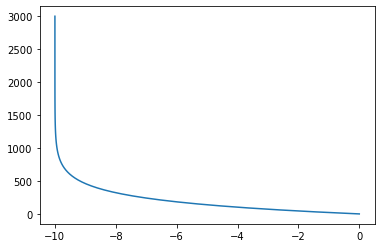

In [8]:
def wind(z):
    return -10*(1-np.exp(-z/200))
z=np.linspace(0,3000,100)
plt.plot(wind(z),z)

## Writing the wind profile

In [9]:
f = open(SCRATCH+'WRF/WRFV4_bp_crosseq/test/em_beta_plane/input_sounding.backup', "r")
alllines=[]
l=[0]
while len(l)>0 :
    l=f.readline().split()
    alllines.append(l)
alllines = alllines[:-1]    

In [11]:
i=0
f = open(SCRATCH+'WRF/WRFV4_bp_crosseq/test/em_beta_plane/input_sounding', "w")
print('{:>10s}{:10.2f}{:>10s}'.format(alllines[0][0],float(alllines[0][1]),alllines[0][2]),file=f)
for i,l in enumerate(alllines[1:]):
    print('{:>10s}{:10.2f}{:>10s}{:10.2f}{:>10s}'.format(l[0],float(l[1]),l[2],wind(float(l[0])),l[4]),file=f)
f.close()

# Lon-lev cross sections

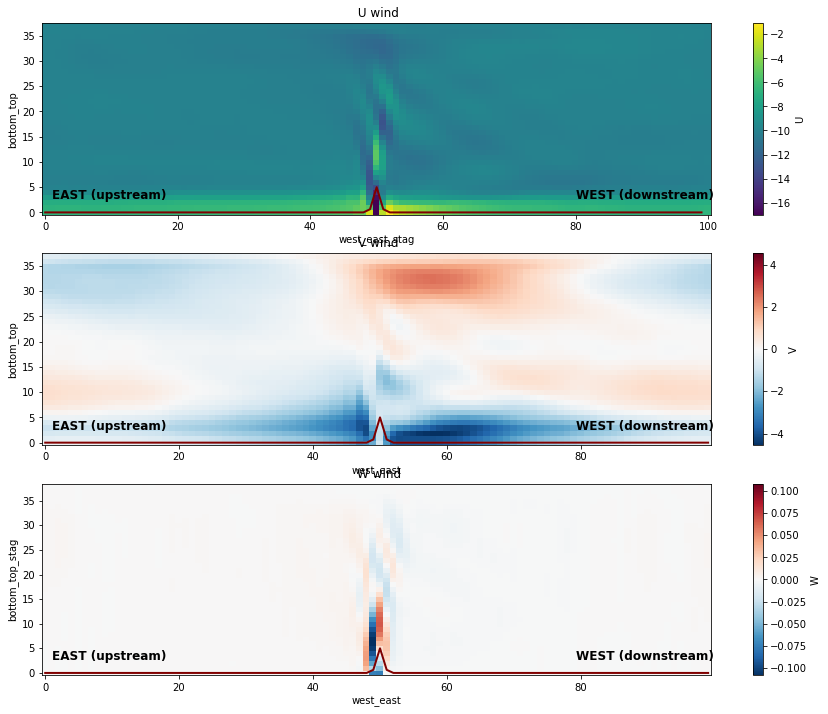

In [347]:
_,ax=plt.subplots(3,1,figsize=(15,12))
ax=ax.reshape(-1)
i=0

channelwrf.U.isel(Time=slice(-400,-1)).mean(["Time","south_north"])[:,::-1].plot(ax=ax[0], x='west_east_stag')
channelwrf.V.isel(Time=slice(-400,-1)).mean(["Time","south_north_stag"])[:,::-1].plot(ax=ax[1], x='west_east')#,vmin=-6,vmax=6,cmap=plt.cm.RdBu_r)
channelwrf.W.isel(Time=slice(-400,-1)).mean(["Time","south_north"])[:,::-1].plot(ax=ax[2], x='west_east')#,vmin=-6,vmax=6,cmap=plt.cm.RdBu_r)

ax[0].plot(channelwrf.west_east, channelwrf.HGT.isel(south_north=0,Time=0)/200,color='maroon',linewidth=2)
ax[1].plot(channelwrf.west_east, channelwrf.HGT.isel(south_north=0,Time=0)/200,color='maroon',linewidth=2)
ax[2].plot(channelwrf.west_east, channelwrf.HGT.isel(south_north=0,Time=0)/200,color='maroon',linewidth=2)

ax[0].set_title(" U wind")
ax[1].set_title(" V wind")
ax[2].set_title(" W wind")

for a in ax:
    add_text(a)



    

Text(0.5, 1.0, 'w**(1/3)')

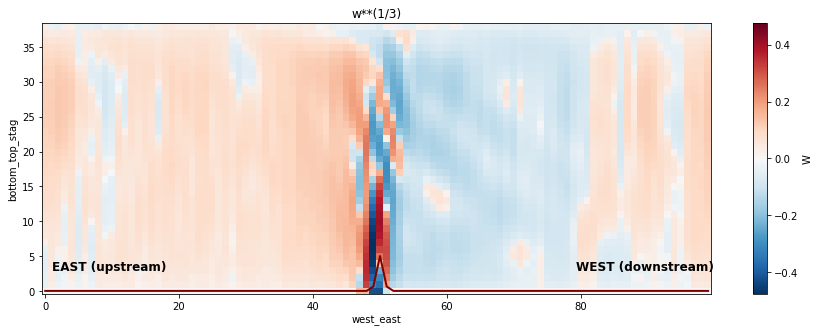

In [365]:
from xarray.ufuncs import sign,log,fabs
_,ax=plt.subplots(1,1,figsize=(15,5))
w=channelwrf.W.isel(Time=slice(-400,-1)).mean(["Time","south_north"])[:,::-1]
(sign(w)*(fabs(w))**(1/3)).plot(ax=ax, x='west_east')
ax.plot(channelwrf.west_east, channelwrf.HGT.isel(south_north=0,Time=0)/200,color='maroon',linewidth=2)
add_text(ax)
ax.set_title("w**(1/3)")

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in sqrt
  return func(*(_execute_task(a, cache) for a in args))


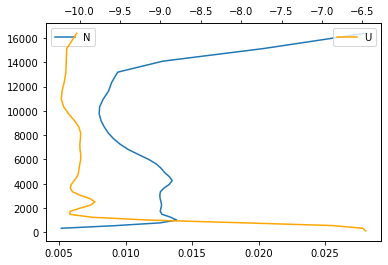

In [344]:
# Brunt vaisala frequency
theta = channelwrf.T.isel(west_east=slice(60,100),Time=slice(400,2400)).mean(["Time","west_east","south_north"]).persist()+300
Z = (channelwrf.PHB+channelwrf.PH).isel(west_east=slice(60,100),Time=slice(400,2400)).mean(["Time","west_east","south_north"]).persist()/9.81
Z=np.interp(channelwrf.ZNU.isel(Time=0)[::-1],channelwrf.ZNW.isel(Time=0)[::-1],np.array(Z)[::-1])[::-1]
dthetadz = np.gradient(theta,Z, edge_order=2)
N = np.sqrt(9.81/theta*dthetadz)

U = channelwrf.U.isel(west_east_stag=slice(60,100),Time=slice(400,2400)).mean(["Time","west_east_stag","south_north"]).persist()


_,ax=plt.subplots(1,1)
ax.plot(N,Z,label="N")
ax.legend()
ax2 = ax.twiny()
ax2.plot(U,Z,label="U",color="orange")
ax2.legend()

So $N \simeq 0.01 s^{-1}$, $u_0 \simeq 10 m/s$,and the mountain width here is 250 km. Hence $N/u_0 = 10^{-3} m^{-1} \gg 1/a \simeq f/u_0$ (Corresponds to figure 3 of Queney 1958)

# QTCM Diagnostics

In [370]:
Aref = A(channelwrf_p.T_p.isel(time=slice(400,1200)).mean(["time","south_north","west_east"]).load(),
         100*channelwrf_p.isel(time=slice(400,1200)).pressure.load()
        )
#Bref = 

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [377]:
Tref = channelwrf_p.T_p.isel(time=slice(400,1200)).mean(["time","south_north","west_east"])
qref = channelwrf_p.q_p.isel(time=slice(400,1200)).mean(["time","south_north","west_east"])
qsatref = qsat(Tref,channelwrf_p.isel(time=slice(400,1200)).pressure.load())                                     

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


(1000.0, 100.0)

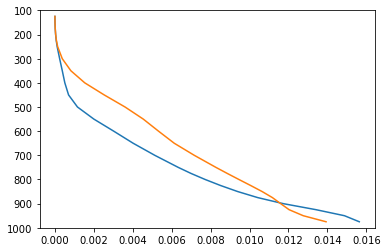

In [380]:
plt.plot(qref,Tref.pressure)
plt.plot(0.8*qsatref,Tref.pressure)
plt.ylim(1000,100)

# Longitudinal cross sections

In [21]:
channelprecip = 4*(channelwrf.RAINC+channelwrf.RAINNC).isel(Time=slice(400,2400)).diff('Time').persist()


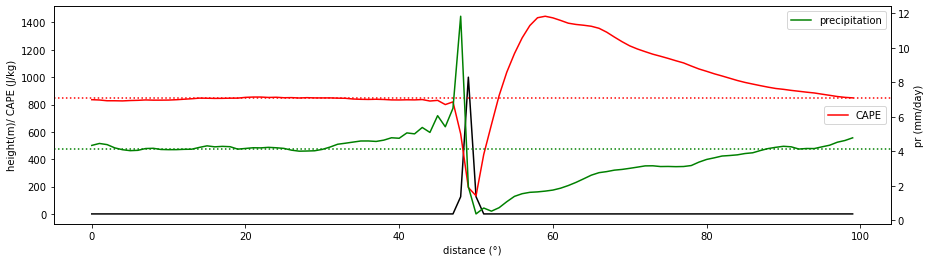

In [35]:
ax,ax2=plotsection(hgt)
ax.set_ylabel("height(m)/ CAPE (J/kg)")
ax.plot(channelCAPEmean.west_east,channelCAPEmean.mean('south_north')[::-1],color='r',label='CAPE')
ax.axhline(channelCAPEmean.isel(west_east=slice(70,90)).mean(['west_east','south_north']),color='r',linestyle=':')

ax2.set_ylabel("pr (mm/day)")
ax2.plot(channelprecip.west_east,channelprecip.mean(['south_north','Time'])[::-1],color='green',label='precipitation')
ax2.axhline(channelprecip.isel(west_east=slice(70,90)).mean(['west_east','south_north','Time']),color='g',linestyle=':')
ax.legend(loc="center right")
ax2.legend()

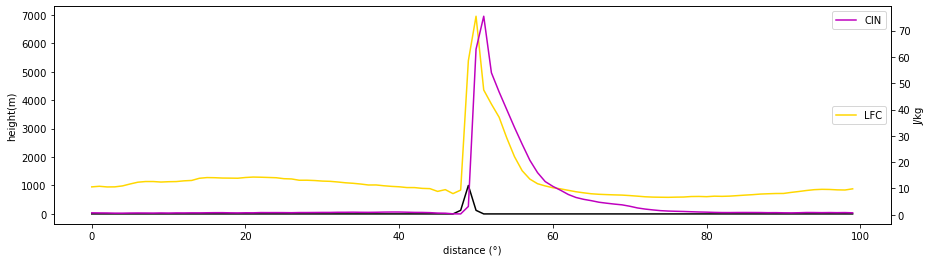

In [298]:
ax,ax2=plotsection(hgt)
ax.plot(channelLFCmean.west_east,channelLFCmean.mean('south_north')[::-1],color='gold',label="LFC")
ax2.set_ylabel("J/kg")
ax2.plot(channelCINmean.west_east,channelCINmean.mean('south_north')[::-1],color='m',label="CIN")
ax.legend(loc="center right")
ax2.legend()

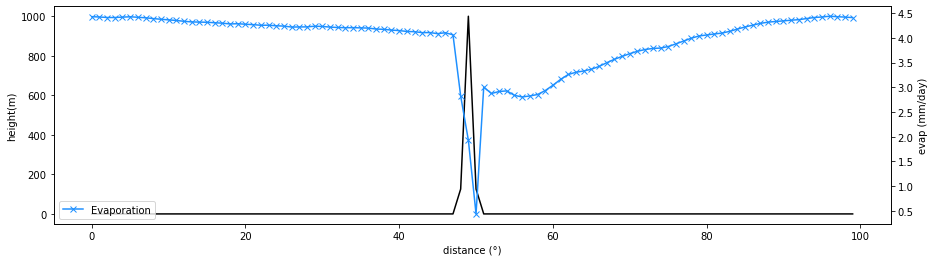

In [272]:
_,ax2 = plotsection(hgt)
ax2.set_ylabel("evap (mm/day)")
ax2.plot(channelwrf.west_east,86400*channelwrf.QFX.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x',color='dodgerblue',label="Evaporation")
ax2.legend()



In [238]:
R = rad_cooling(channelwrf.isel(Time=slice(400,2400))).mean(['south_north']).persist()

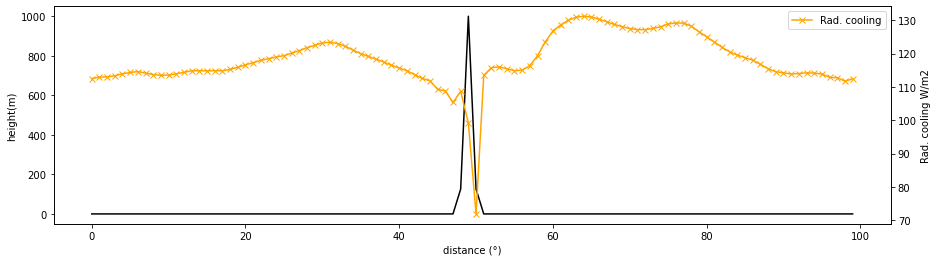

In [274]:
_,ax2 = plotsection(hgt)
ax2.set_ylabel("Rad. cooling W/m2")
ax2.plot(R.west_east,R[::-1],'-x',color='orange',label="Rad. cooling")
ax2.legend()

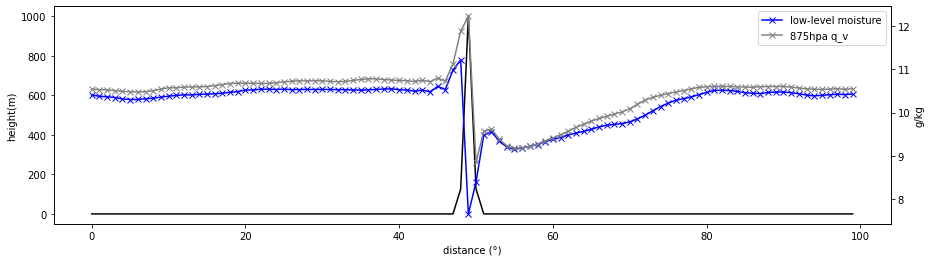

In [282]:
_,ax2 = plotsection(hgt)
ax2.set_ylabel("g/kg")
ax2.plot(channelwrf.west_east,1e3*channelwrf.QVAPOR.isel(bottom_top=5,Time=slice(-800,-1)).mean(['south_north','Time'])[::-1],'-x',color='blue',label="low-level moisture")
ax2.plot(channelwrf_p.west_east,1e3*channelwrf_p.q_p.sel(pressure=875.).isel(time=slice(-800,-1)).mean(['south_north','time'])[::-1],'-x',color='grey',label="875hpa q_v")
ax2.legend()


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


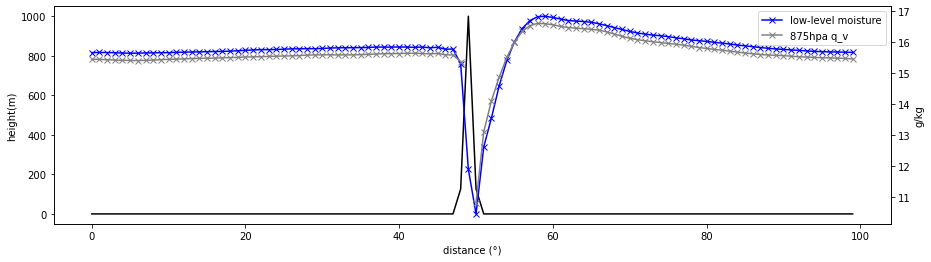

In [307]:
_,ax2 = plotsection(hgt)
ax2.set_ylabel("g/kg")
ax2.plot(channelwrf.west_east,1e3*channelwrf.QVAPOR.isel(bottom_top=1,Time=slice(-800,-1)).mean(['south_north','Time'])[::-1],'-x',color='blue',label="low-level moisture")
ax2.plot(channelwrf_p.west_east,1e3*channelwrf_p.q_p.sel(pressure=975.).isel(time=slice(-800,-1)).mean(['south_north','time'])[::-1],'-x',color='grey',label="875hpa q_v")
ax2.legend()


In [213]:
Mh,Ms,Mq = M(channelwrf_p.Z_p.isel(pressure=slice(6,29),time=slice(400,1200)).mean(["time","south_north"]).load(),
             channelwrf_p.q_p.isel(pressure=slice(6,29),time=slice(400,1200)).mean(["time","south_north"]).load(),
             channelwrf_p.T_p.isel(pressure=slice(6,29),time=slice(400,1200)).mean(["time","south_north"]).load(),
             100*channelwrf_p.isel(pressure=slice(6,29),time=slice(400,1200)).pressure.load()
            )

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


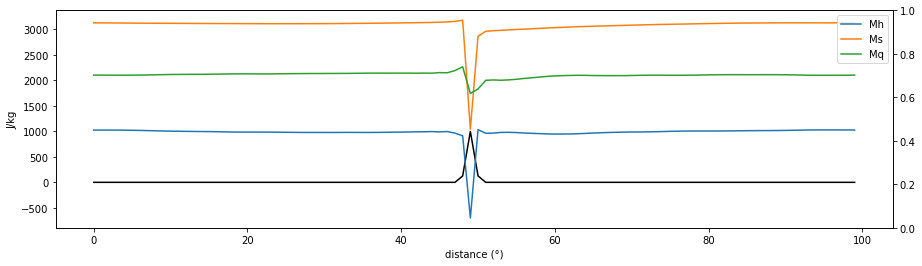

In [303]:
ax,ax2 = plotsection(hgt)
ax.set_ylabel("J/kg")
ax.plot(Mh.west_east,Mh[::-1],label="Mh")
ax.plot(Ms.west_east,Ms[::-1],label="Ms")
ax.plot(Mq.west_east,Mq[::-1],label="Mq")
ax.legend()

#ax2.plot(Mh.west_east,Ms[::-1]/Mh[::-1],label="Ms/Mh",color="m")
#ax2.legend(loc="center right")

In [306]:
hgt.isel(west_east=slice(48,51))

<xarray.DataArray 'HGT' (west_east: 3)>
dask.array<getitem, shape=(3,), dtype=float32, chunksize=(3,), chunktype=numpy.ndarray>
Dimensions without coordinates: west_east

## soundings

O° is upstream and 100° is downstream !!


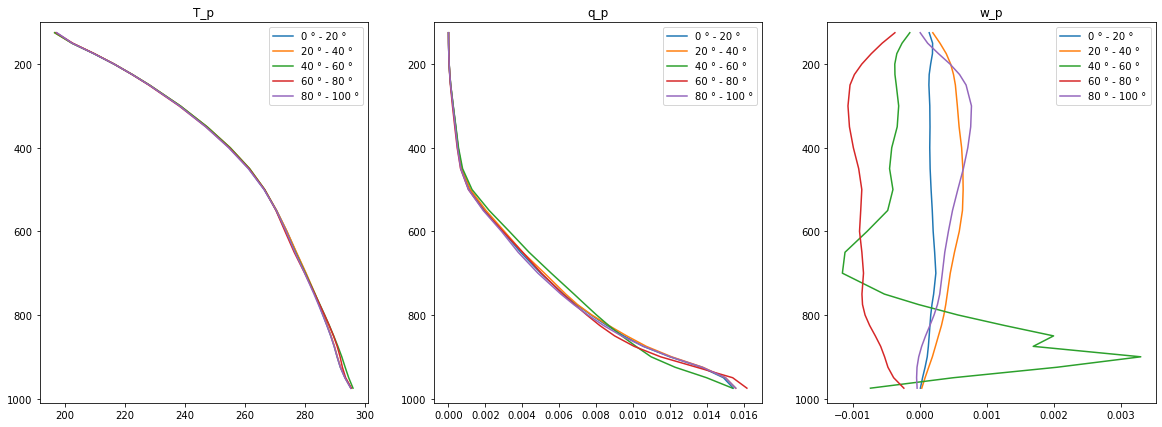

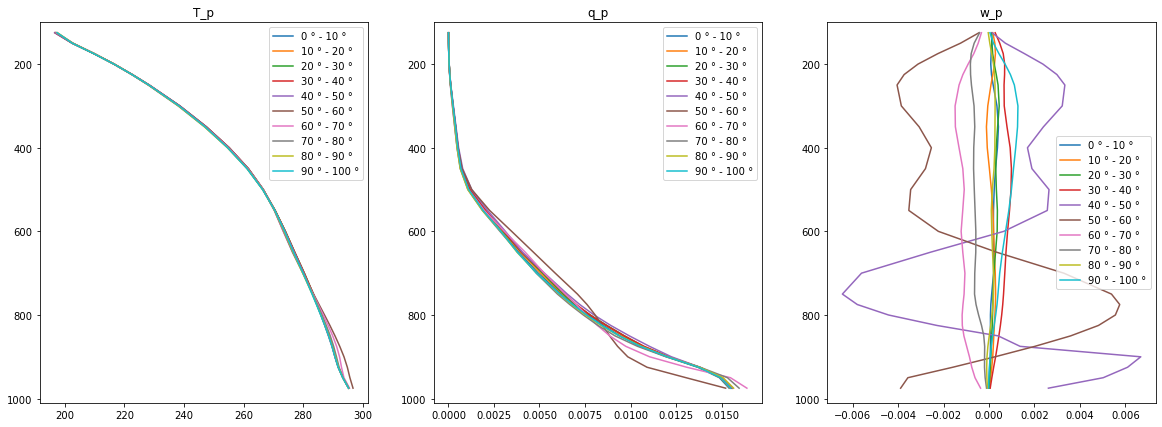

In [304]:
print("O° is upstream and 100° is downstream !!")
for disc in (20,10):
    fig, ax = plt.subplots(1,3,figsize=(20,7))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",RuntimeWarning)
        for j,var in enumerate(["T_p","q_p","w_p"]):
            n=100//disc
            for i in range(n):
                ax[j].plot(channelwrf_p[var].isel(west_east=slice(disc*(n-1-i),disc*(n-i)),time=slice(400,1200)).mean(["time","south_north","west_east"]).load(),channelwrf_p.pressure,label="%i ° - %i °"%(disc*i,disc*(i+1)))
            ax[j].set_title(var)
            ax[j].set_ylim(1010,100)
            ax[j].legend()

# Fixed evap & radiation

## Setting up radiation

### RTHRATEN

In [92]:
wrfouts = xr.open_mfdataset(sorted(glob.glob("/global/cscratch1/sd/qnicolas/WRF/WRFV4_channel/test/em_beta_plane/wrfout_*")),combine='nested',concat_dim='Time',parallel=True)
wrfou24 = xr.open_mfdataset(sorted(glob.glob("/global/cscratch1/sd/qnicolas/WRF/WRFV4_channel/test/em_beta_plane/wrfout24_*")),combine='nested',concat_dim='Time',parallel=True)


In [410]:
rtest = rad_cooling(wrfouts.mean(['south_north'])).persist()

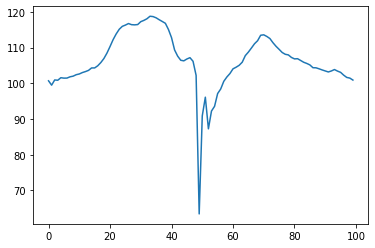

In [412]:
plt.plot(rtest.west_east,rtest)

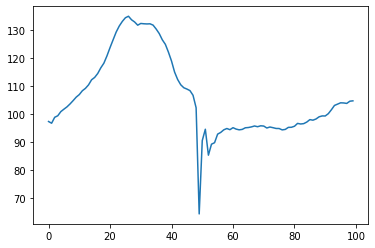

In [419]:
def rad_cooling_2(sim):
    mSWUPT = sim.SWUPT.mean('Time')
    mSWDNT = sim.SWDNT.mean('Time')
    mSWUPB = sim.SWUPB.mean('Time')
    mSWDNB = sim.SWDNB.mean('Time')
    mLWUPT = sim.LWUPT.mean('Time')
    mLWDNT = sim.LWDNT.mean('Time')
    mLWUPB = sim.LWUPB.mean('Time')
    mLWDNB = sim.LWDNB.mean('Time')
    return mSWUPT-mSWDNT-mSWUPB+mSWDNB+mLWUPT-mLWDNT-mLWUPB+mLWDNB
plt.plot(rtest.west_east,rad_cooling_2(wrfouts.mean(['south_north'])).persist())

In [54]:
radcooling.mean().load()

<xarray.DataArray ()>
array(-137.04405401)
Coordinates:
    XLAT     float32 10.0
    XLONG    float32 0.0
    XTIME    datetime64[ns] 1970-01-01

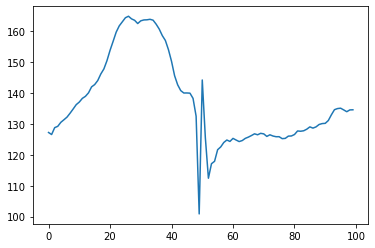

In [52]:
Cp=1004.
P_W = np.interp(wrfouts.ZNW.isel(Time=0)[::-1],wrfouts.ZNU.isel(Time=0)[::-1],wrfouts.PB[0,::-1,0,0])[::-1]
mass = xr.DataArray((P_W[:-1]-P_W[1:])/9.81,coords=wrfouts.PB[0,::-1,0,0].coords)
radcooling=(Cp*mass*wrfou24.RTHRATEN).sum('bottom_top')
plt.plot(radcooling.west_east,-radcooling.mean(['south_north','Time']))

In [60]:
wrfou24.RTHRATEN.isel(Time=slice(200,360),west_east=slice(70,100)).mean().load()

<xarray.DataArray 'RTHRATEN' ()>
array(-1.4473522e-05, dtype=float32)

In [61]:
wrfou24.RTHRATEN.isel(Time=slice(200,360),west_east=slice(20,45)).mean().load()

<xarray.DataArray 'RTHRATEN' ()>
array(-1.775727e-05, dtype=float32)

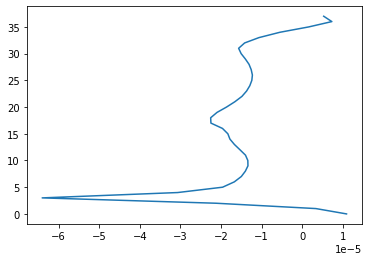

In [94]:
plt.plot(wrfou24.RTHRATEN.isel(Time=slice(200,360),west_east=slice(70,100)).mean(['west_east','south_north','Time']).load(),wrfou24.bottom_top)

### T_eq

In [48]:
Tmean=channelwrf_p.T_p.isel(time=slice(800,1200)).mean(["time","south_north","west_east"]).load()
p = np.polyfit(np.array(Tmean.pressure/1000)[4:-1],np.array(Tmean)[4:-1],4)

parr=np.linspace(0,1010,1000)
fit = np.sum(p[::-1]*(np.ones(5)*parr[:,None]/1000)**range(5),axis=1)

/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


/global/homes/q/qnicolas/.conda/envs/era5/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


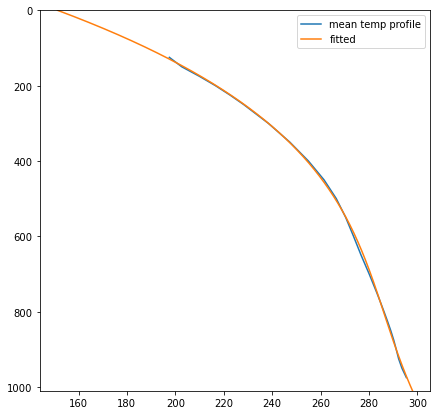

In [440]:
fig, ax = plt.subplots(1,1,figsize=(7,7))
ax.plot(Tmean,Tmean.pressure,label="mean temp profile")
ax.plot(fit,parr,label='fitted')
ax.set_ylim(1010,0)
ax.legend()

## Analysis

In [46]:
%%time
channelwrf_fe = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel_fe_radrelax.wrf.100x10.mountain.100km.300d/",nfiles=30)
channelwrf_fe_p = extract_wrfpro("/global/cscratch1/sd/qnicolas/wrfdata/processed/channel_fe_radrelax.wrf.100x10.mountain.100km.300d/",nfiles=30)


CPU times: user 4.96 s, sys: 1.7 s, total: 6.66 s
Wall time: 8.41 s


In [14]:
channelprecip_fe = 4*(channelwrf_fe.RAINC+channelwrf_fe.RAINNC).isel(Time=slice(-800,-1)).diff('Time').persist()

In [15]:
%time channelcapecin_fe = compute_cape("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel_fe_radrelax.wrf.100x10.mountain.100km.300d/")
channelCAPEmean_fe = channelcapecin_fe.isel(mcape_mcin_lcl_lfc=0,Time=slice(400,1200)).mean('Time')

CPU times: user 250 ms, sys: 296 ms, total: 546 ms
Wall time: 7.46 s


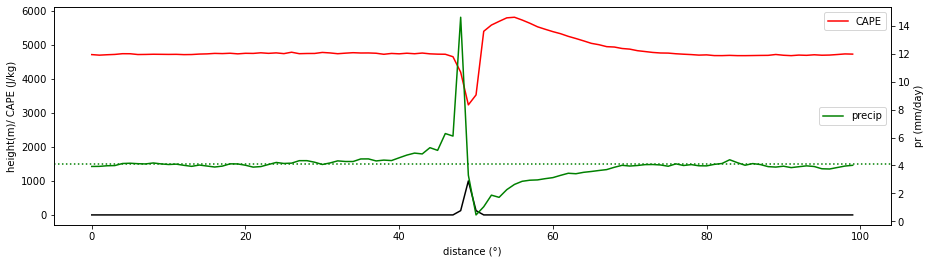

In [33]:
ax,ax2=plotsection(hgt)

ax.set_xlabel("distance (°)")
ax.set_ylabel("height(m)/ CAPE (J/kg)")
ax.plot(channelCAPEmean_fe.west_east,channelCAPEmean_fe.mean('south_north')[::-1],color='r',label='CAPE')

ax2.set_ylabel("pr (mm/day)")
ax2.plot(channelprecip_fe.west_east,channelprecip_fe.mean(['south_north','Time'])[::-1],color='green',label='precip')
ax2.axhline(channelprecip_fe.isel(west_east=slice(70,90)).mean(['west_east','south_north','Time']),color='g',linestyle=':')
ax.legend()
ax2.legend(loc="center right")


Text(0.5, 1.0, 'Evaporation')

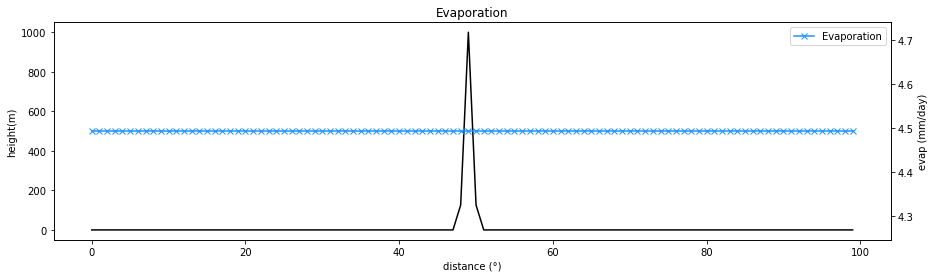

In [29]:
_,ax2 = plotsection(hgt)
ax2.set_ylabel("evap (mm/day)")
ax2.plot(channelwrf_fe.west_east,86400*channelwrf_fe.QFX.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x',color='dodgerblue',label="Evaporation")
ax2.legend()
ax2.set_title("Evaporation")

In [28]:
Cp=1004.
P_W = np.interp(channelwrf_fe.ZNW.isel(Time=0)[::-1],channelwrf_fe.ZNU.isel(Time=0)[::-1],channelwrf_fe.PB[0,::-1,0,0])[::-1]
mass = xr.DataArray((P_W[:-1]-P_W[1:])/9.81,coords=channelwrf_fe.PB[0,::-1,0,0].coords)
radcooling=(Cp*mass*channelwrf_fe.RTHRATEN).sum('bottom_top')

Text(0.5, 1.0, 'Radiative cooling')

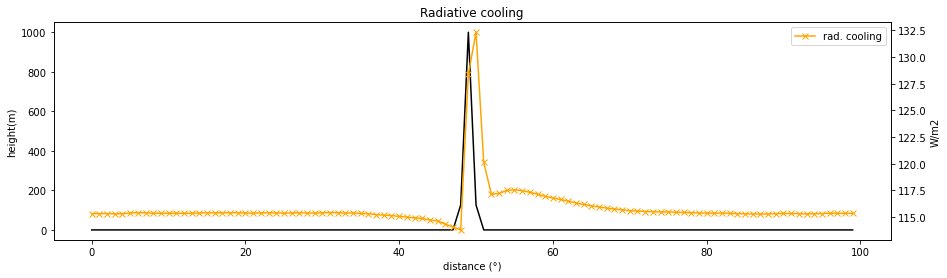

In [31]:
_,ax2 = plotsection(hgt)
ax2.set_ylabel("W/m2")
ax2.plot(channelwrf_fe.west_east,-radcooling.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x',color='orange',label="rad. cooling")
ax2.legend()
ax2.set_title("Radiative cooling")

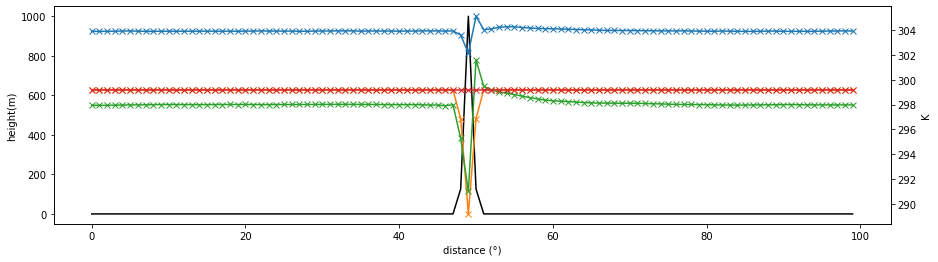

In [38]:
_,ax2 = plotsection(hgt)
ax2.set_ylabel("K")
ax2.plot(channelwrf_fe.west_east,channelwrf_fe.T2.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x')
ax2.plot(channelwrf_fe.west_east,channelwrf_fe.SST.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x')
ax2.plot(channelwrf.west_east,channelwrf.T2.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x')
ax2.plot(channelwrf.west_east,channelwrf.SST.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x')

O° is upstream and 100° is downstream !!


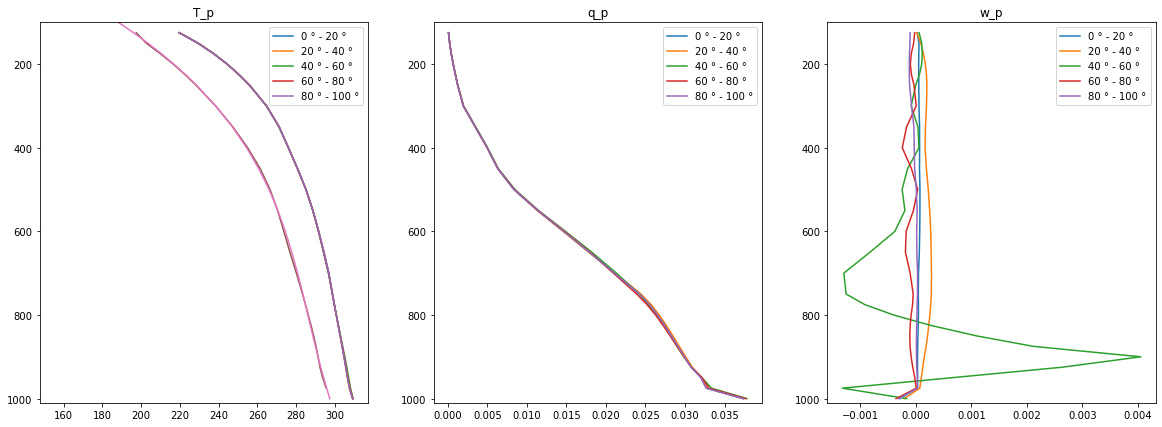

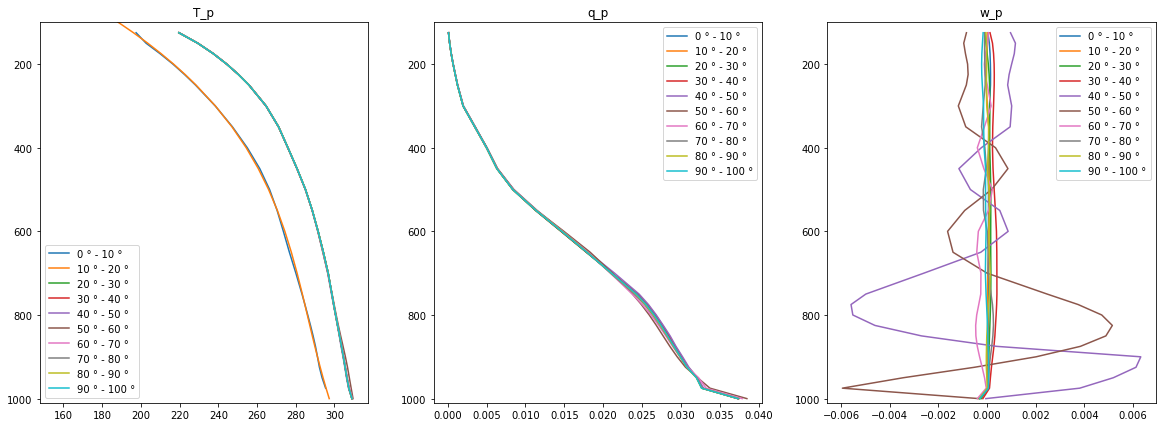

In [68]:
print("O° is upstream and 100° is downstream !!")
for disc in (20,10):
    fig, ax = plt.subplots(1,3,figsize=(20,7))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",RuntimeWarning)
        for j,var in enumerate(["T_p","q_p","w_p"]):
            n=100//disc
            for i in range(n):
                ax[j].plot(channelwrf_fe_p[var].isel(west_east=slice(disc*(n-1-i),disc*(n-i)),time=slice(400,1200)).mean(["time","south_north","west_east"]).load()[4:],channelwrf_fe_p.pressure[4:],label="%i ° - %i °"%(disc*i,disc*(i+1)))
            ax[j].set_title(var)
            ax[j].set_ylim(1010,100)
            ax[j].legend()
        ax[0].plot(Tmean,Tmean.pressure,label="ref profile")
        pnorm = Tmean.pressure/1000
        a0 = 151.3
        a1 = 416.7
        a2 = -494.3
        a3 = 254.9
        a4 = -31.3
        teq = a0 + a1*pnorm + a2*pnorm**2 + a3*pnorm**3 + a4*pnorm**4
        ax[0].plot(teq,Tmean.pressure,label="ref profile 2")
        

In [72]:
#evap
4.3/86400*2.26e6

112.47685185185185

In [73]:
9051*1004*1.5e-5

136.30806

## With fixed radiative cooling

In [81]:
%%time
channelwrf_fefr = extract_wrfout("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel_fe_frad.wrf.100x10.mountain.100km.300d/",nfiles=30)
channelwrf_fefr_p = extract_wrfpro("/global/cscratch1/sd/qnicolas/wrfdata/processed/channel_fe_frad.wrf.100x10.mountain.100km.300d/",nfiles=30)


CPU times: user 3.75 s, sys: 1.19 s, total: 4.94 s
Wall time: 3.72 s


In [82]:
channelprecip_fefr = 4*(channelwrf_fefr.RAINC+channelwrf_fefr.RAINNC).isel(Time=slice(-800,-1)).diff('Time').persist()

In [83]:
%time channelcapecin_fefr = compute_cape("/global/cscratch1/sd/qnicolas/wrfdata/saved/channel_fe_frad.wrf.100x10.mountain.100km.300d/")
channelCAPEmean_fefr = channelcapecin_fefr.isel(mcape_mcin_lcl_lfc=0,Time=slice(-800,-1)).mean('Time')

CPU times: user 194 ms, sys: 538 ms, total: 732 ms
Wall time: 5.19 s


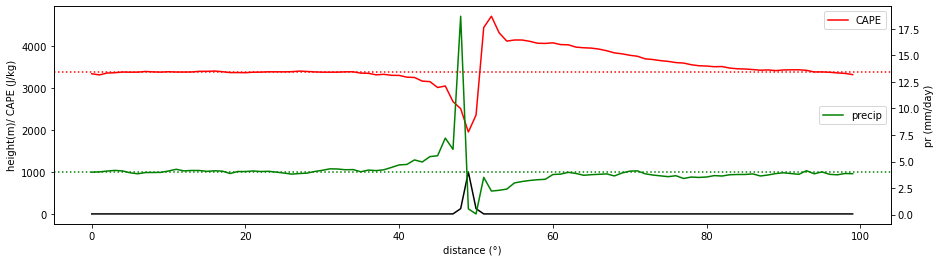

In [95]:
ax,ax2=plotsection(hgt)

ax.set_xlabel("distance (°)")
ax.set_ylabel("height(m)/ CAPE (J/kg)")
ax.plot(channelCAPEmean_fefr.west_east,channelCAPEmean_fefr.mean('south_north')[::-1],color='r',label='CAPE')
ax.axhline(channelCAPEmean_fefr.isel(west_east=slice(70,90)).mean(['west_east','south_north']),color='r',linestyle=':')

ax2.set_ylabel("pr (mm/day)")
ax2.plot(channelprecip_fefr.west_east,channelprecip_fefr.mean(['south_north','Time'])[::-1],color='green',label='precip')
ax2.axhline(channelprecip_fefr.isel(west_east=slice(70,90)).mean(['west_east','south_north','Time']),color='g',linestyle=':')
ax.legend()
ax2.legend(loc="center right")


Text(0.5, 1.0, 'Evaporation')

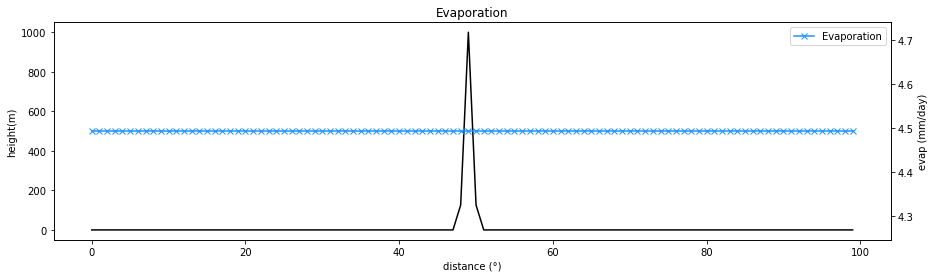

In [29]:
_,ax2 = plotsection(hgt)
ax2.set_ylabel("evap (mm/day)")
ax2.plot(channelwrf_fefr.west_east,86400*channelwrf_fefr.QFX.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x',color='dodgerblue',label="Evaporation")
ax2.legend()
ax2.set_title("Evaporation")

In [85]:
channelwrf_fefr.RTHRATEN.mean().load()

<xarray.DataArray 'RTHRATEN' ()>
array(-1.49852585e-05, dtype=float32)

In [87]:
Cp=1004.
P_W = np.interp(channelwrf_fefr.ZNW.isel(Time=0)[::-1],channelwrf_fefr.ZNU.isel(Time=0)[::-1],channelwrf_fefr.PB[0,::-1,0,0])[::-1]
mass = xr.DataArray((P_W[:-1]-P_W[1:])/9.81,coords=channelwrf_fefr.PB[0,::-1,0,0].coords)
radcooling=(Cp*mass*channelwrf_fefr.RTHRATEN).sum('bottom_top')

(130.0, 140.0)

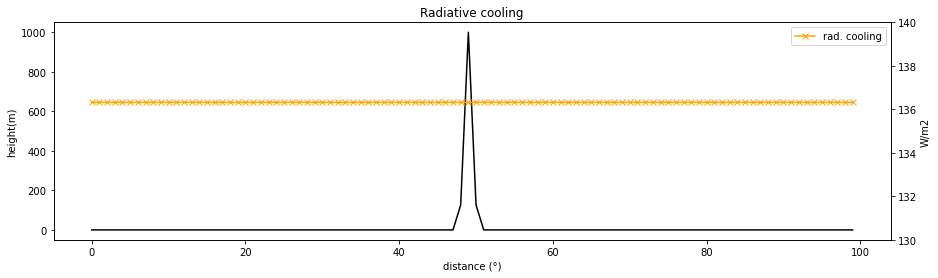

In [89]:
_,ax2 = plotsection(hgt)
ax2.set_ylabel("W/m2")
ax2.plot(channelwrf_fefr.west_east,-radcooling.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x',color='orange',label="rad. cooling")
ax2.legend()
ax2.set_title("Radiative cooling")
ax2.set_ylim(130,140)

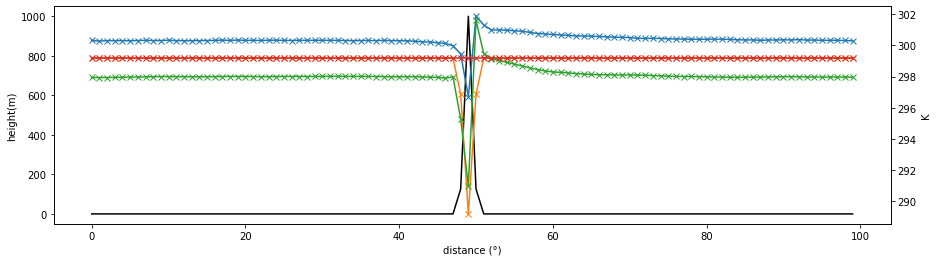

In [90]:
_,ax2 = plotsection(hgt)
ax2.set_ylabel("K")
ax2.plot(channelwrf_fefr.west_east,channelwrf_fefr.T2.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x')
ax2.plot(channelwrf_fefr.west_east,channelwrf_fefr.SST.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x')
ax2.plot(channelwrf.west_east,channelwrf.T2.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x')
ax2.plot(channelwrf.west_east,channelwrf.SST.isel(Time=slice(-400,-1)).mean(['south_north','Time'])[::-1],'-x')

O° is upstream and 100° is downstream !!


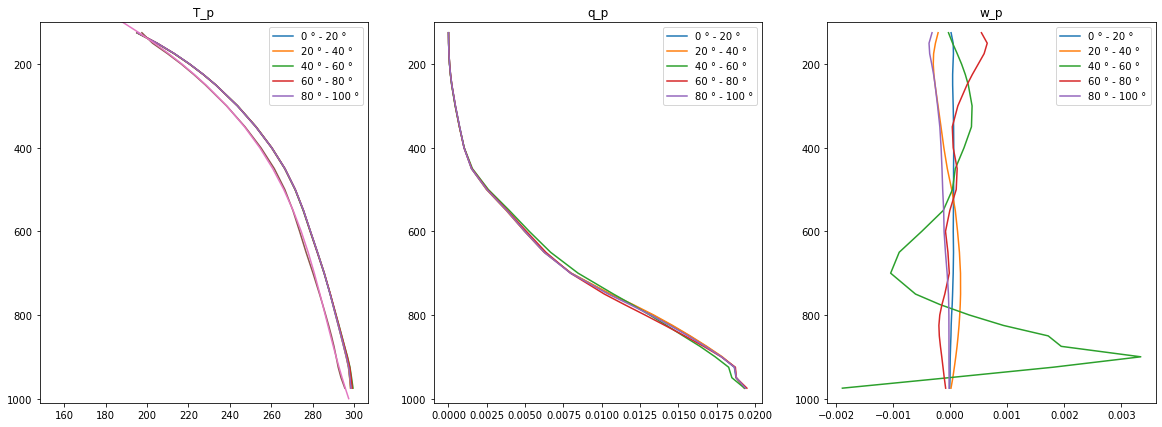

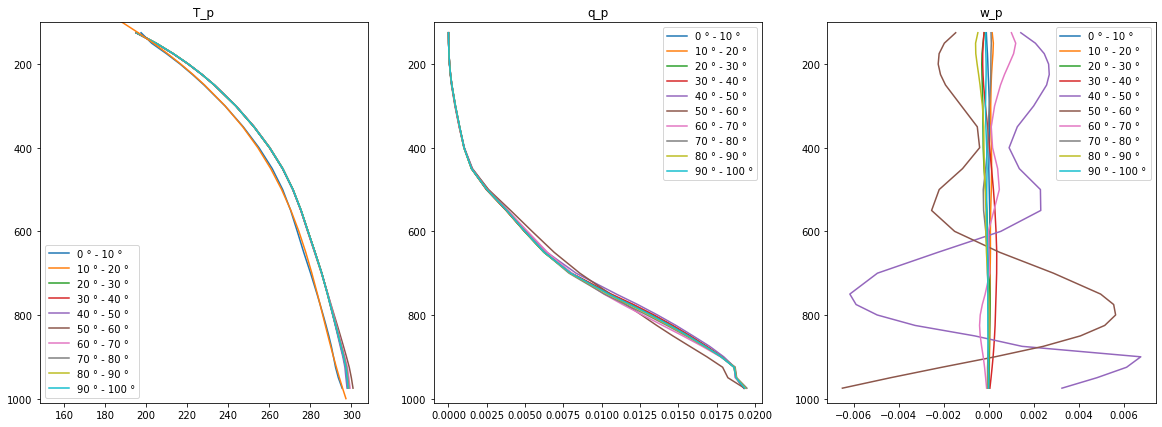

In [91]:
print("O° is upstream and 100° is downstream !!")
for disc in (20,10):
    fig, ax = plt.subplots(1,3,figsize=(20,7))
    with warnings.catch_warnings():
        warnings.simplefilter("ignore",RuntimeWarning)
        for j,var in enumerate(["T_p","q_p","w_p"]):
            n=100//disc
            for i in range(n):
                ax[j].plot(channelwrf_fefr_p[var].isel(west_east=slice(disc*(n-1-i),disc*(n-i)),time=slice(400,1200)).mean(["time","south_north","west_east"]).load()[4:],channelwrf_fefr_p.pressure[4:],label="%i ° - %i °"%(disc*i,disc*(i+1)))
            ax[j].set_title(var)
            ax[j].set_ylim(1010,100)
            ax[j].legend()
        ax[0].plot(Tmean,Tmean.pressure,label="ref profile")
        pnorm = Tmean.pressure/1000
        a0 = 151.3
        a1 = 416.7
        a2 = -494.3
        a3 = 254.9
        a4 = -31.3
        teq = a0 + a1*pnorm + a2*pnorm**2 + a3*pnorm**3 + a4*pnorm**4
        ax[0].plot(teq,Tmean.pressure,label="ref profile 2")
        

Text(0.5, 1.0, 'w**(1/3)')

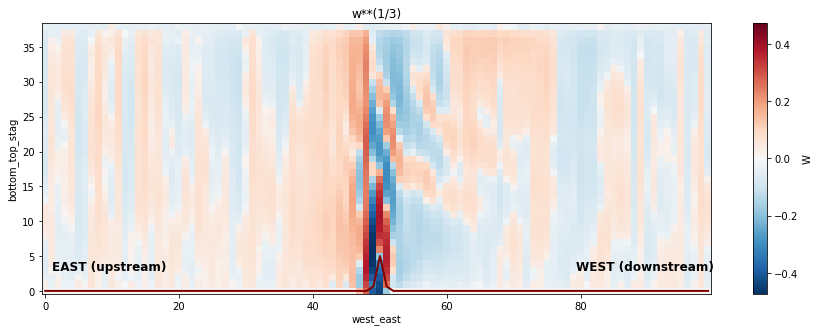

In [96]:
from xarray.ufuncs import sign,log,fabs
_,ax=plt.subplots(1,1,figsize=(15,5))
w=channelwrf_fefr.W.isel(Time=slice(-400,-1)).mean(["Time","south_north"])[:,::-1]
(sign(w)*(fabs(w))**(1/3)).plot(ax=ax, x='west_east')
ax.plot(channelwrf_fefr.west_east, channelwrf_fefr.HGT.isel(south_north=0,Time=0)/200,color='maroon',linewidth=2)
add_text(ax)
ax.set_title("w**(1/3)")

# M_h tests on reference sounding

In [175]:
# Jordan Sounding
pjordan = 100*np.array([100.,125.,150.,175.,200., 250., 300., 350., 400., 450., 500., 550., 600.,650., 700., 750., 800., 850., 900., 950.,1000.,1016.3])
Tjordan = 273.15+np.array([-74.6,-71.5,-66.7,-61.,-55.3,-44.2,-34.5,-26.1,-18.9,-12.8,-7.6,-3.,1.,4.6,7.9,10.7,13.1,15.6,18.3,21.2,24.3,24.7])
pjordan=pjordan[4:]
Tjordan=Tjordan[4:]

(101700.0, 0.0)

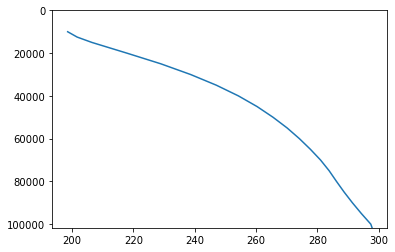

In [123]:
plt.plot(Tjordan,pjordan)
plt.ylim(100*1017,0)

(101700.0, 0.0)

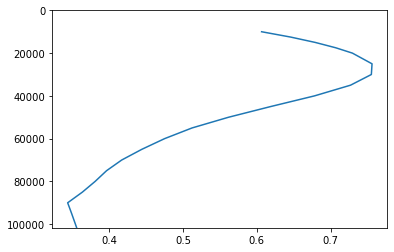

In [124]:
plt.plot(A_npy(Tjordan,pjordan),pjordan)
plt.ylim(100*1017,0)

(101700.0, 0.0)

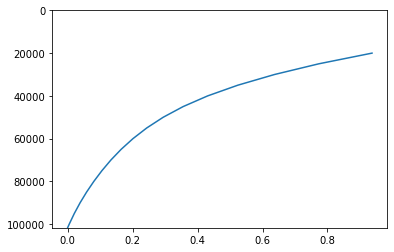

In [178]:
plt.plot(Aplus_npy(Tjordan,pjordan),pjordan)
plt.ylim(100*1017,0)

(101700.0, 0.0)

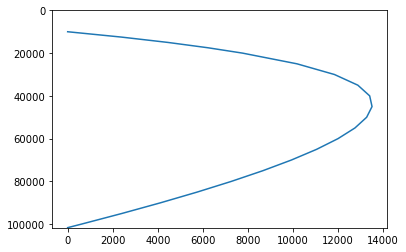

In [169]:
plt.plot(Omega_npy(Tjordan,pjordan),pjordan)
plt.ylim(100*1017,0)